### Домашняя работа к Уроку 6
### Студент: Абрамов А.В.

#### 1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
https://www.kaggle.com/carlolepelaars/camvid

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

#### В качестве датасета выбран Roads Segmentation Dataset (https://www.kaggle.com/datasets/trainingdatapro/roads-segmentation-dataset) - фотографии с заднего регистратора автомобиля, движущегося на слабо оживленной загородной трассе + размеченные сегментами по типу объектов картинки. Разрешение 1280х720, 31 шт.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import misc
from PIL import Image

from keras.preprocessing import image
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
import pydot
import graphviz
import keras
from IPython.display import clear_output

In [51]:
path_imgs = './images/'
path_masks = './masks/'

imgs_paths = list(Path(path_imgs).iterdir())
masks_paths = list(Path(path_masks).iterdir())

In [52]:
images = []
masks = []
image_size = (720, 1280)

for i_img, i_mask in zip(imgs_paths, masks_paths):
    images.append(image.load_img(i_img, target_size=image_size))
    masks.append(image.load_img(i_mask, target_size=image_size))

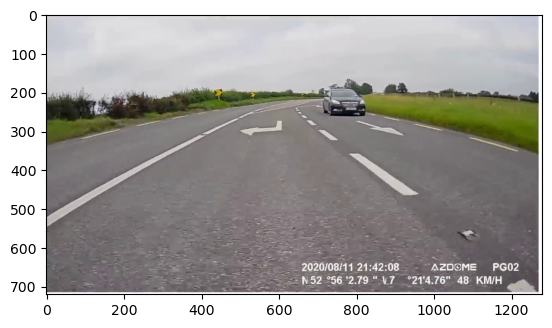

In [53]:
plt.imshow(images[1].convert('RGBA'))
plt.show()

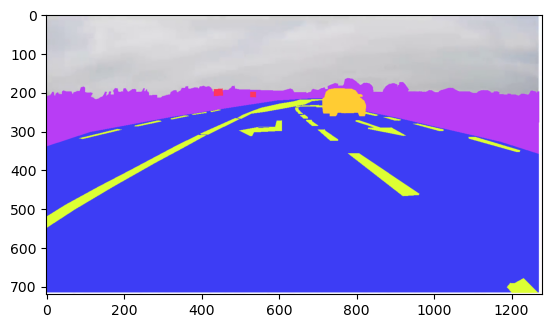

In [54]:
plt.imshow(masks[1].convert('RGBA'))
plt.show()

In [55]:
X = []

for img in images:
  x = image.img_to_array(img)
  X.append(x)

X = np.array(X)

In [56]:
print(X.shape)

(31, 720, 1280, 3)


In [57]:
Y = []

for msk in masks:
  y = image.img_to_array(msk)
  Y.append(y)

y = np.array(Y)

In [58]:
color_map = pd.read_xml('annotations.xml')

In [59]:
N = 20
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [60]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20, 720, 1280, 3)
(20, 720, 1280, 3)
(11, 720, 1280, 3)
(11, 720, 1280, 3)


In [61]:
import keras.backend as K


def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

In [62]:
def Unet(num_classes=3, input_shape=(720, 1280, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [63]:
model_1 = Unet(3, (720, 1280, 3))

plot_model(model_1, to_file='model_1.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [64]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model_1.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 720, 1280, 3)]       0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 720, 1280, 64)        1792      ['input_9[0][0]']             
                                                                                                  
 batch_normalization_152 (B  (None, 720, 1280, 64)        256       ['block1_conv1[0][0]']        
 atchNormalization)                                                                               
                                                                                                  
 activation_152 (Activation  (None, 720, 1280, 64)        0         ['batch_normalization_15

 activation_160 (Activation  (None, 90, 160, 512)         0         ['batch_normalization_160[0][0
 )                                                                  ]']                           
                                                                                                  
 block4_conv3 (Conv2D)       (None, 90, 160, 512)         2359808   ['activation_160[0][0]']      
                                                                                                  
 batch_normalization_161 (B  (None, 90, 160, 512)         2048      ['block4_conv3[0][0]']        
 atchNormalization)                                                                               
                                                                                                  
 conv2d_transpose_24 (Conv2  (None, 180, 320, 256)        524544    ['batch_normalization_161[0][0
 DTranspose)                                                        ]']                           
          

                                                                                                  
 conv2d_61 (Conv2D)          (None, 720, 1280, 64)        36928     ['activation_169[0][0]']      
                                                                                                  
 batch_normalization_170 (B  (None, 720, 1280, 64)        256       ['conv2d_61[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_170 (Activation  (None, 720, 1280, 64)        0         ['batch_normalization_170[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_62 (Conv2D)          (None, 720, 1280, 3)         1731      ['activation_170[0][0]']      
          

In [65]:
sample_image = X_test[0]
sample_mask = y_test[0]

In [66]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

1/1 [==============================] - 3s 3s/step
(1, 720, 1280)


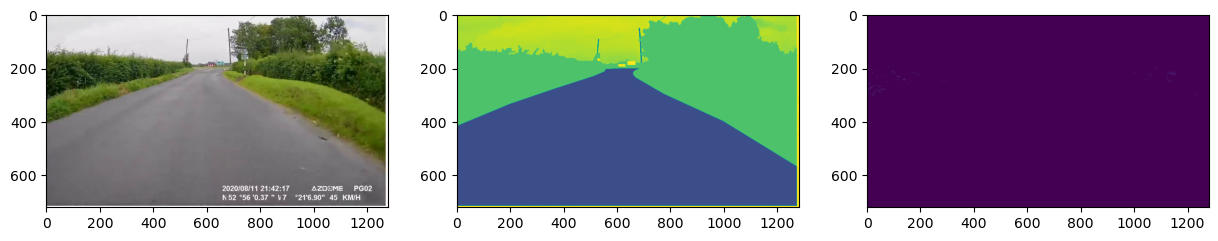

In [67]:
show_predictions(model_1)

In [68]:
history = model_1.fit(X_train, y_train,
                      epochs=1,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

20/20 [==============================] - 389s 19s/step - loss: 714.8566 - dice_coef: 0.8992 - val_loss: 1131215.5000 - val_dice_coef: 0.8667


In [70]:
pred = model_1.predict(X_test)
print(pred.shape)

1/1 [==============================] - 35s 35s/step
(11, 720, 1280, 3)


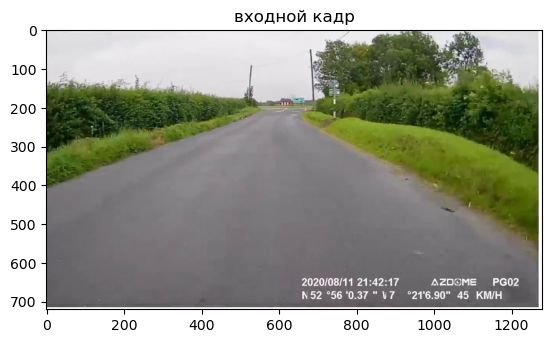

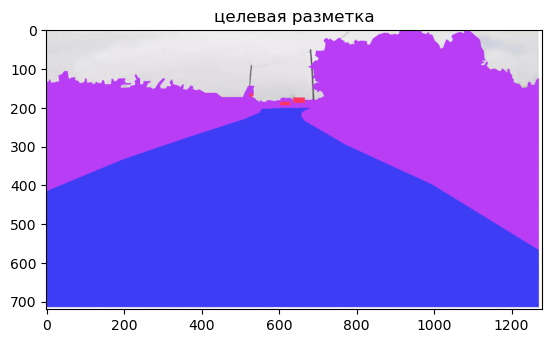

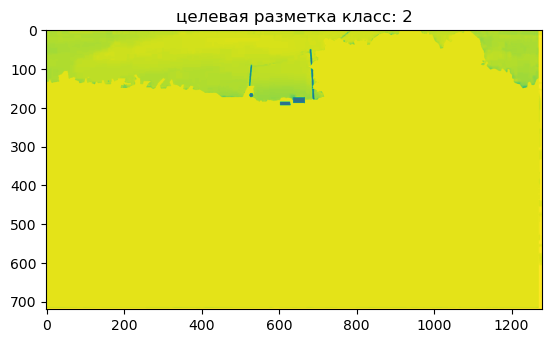

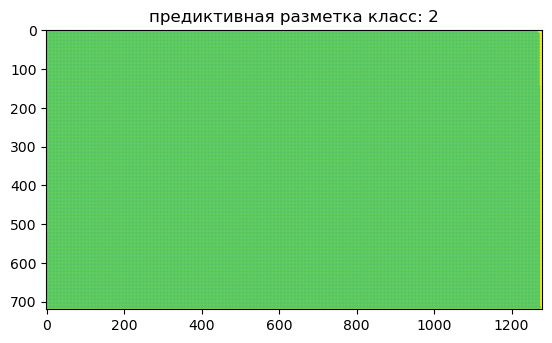

In [75]:
n = 0
class_ = 2
plt.imshow(images[N + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

#### 2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

#### Вывод: даже при одном прогоне (который занял немало времени 6 мин 30 сек - из-за большого разрешения картинок) удалось достичь значения коэффициента DICE на тестовом наборе 0.8667. Точность увеличивается при увеличении кол-ва прогонов, и, конечно, при снижении кол-ва размечаемых сегментов.